# Multi-Layer Perceptron (MLP) <br>
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [17]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
    #print(w)
    context = [0] * block_size # start with a list of zeros
    for ch in w + '.':
        ix = stoi[ch] # look up the index of the ch-th character
        X.append(context) # append the context to list X
        Y.append(ix) # append the index to list Y
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append to keep the length equals to block_size

X = torch.tensor(X)
Y = torch.tensor(Y)

What it means to embed 27 features into 2 features is a matrix multiplication of a one hot encoded input with shape (1, 27) and a weight matrix of (27,2). <br>
In pytorch, <br>
if C is the weight matrix (27,2)<br>
and X1 is a scalar (1) -> X1_oh : transform into one hot encoded input (1,27)<br>
we can achieve the embedding in two ways<br>
1. F.one_hot(torch.tensor(X1, num_classes = 27).float() @ C
2. C[X1] -> easier to use


In short, the embedding is just a linear function that transform i number of features to j number of features

In [18]:
X.shape

torch.Size([32, 3])

For the first 5 words, the X shape is (32 ,3) -> which means we have 32 training examples with 3 characters <br>
For each training example, the shape is (1, 3)<br><br>
Embed this to a (27,2) matrix, we first need to one hot encode each input so that we have (1, 27) -> 3 inputs means (3, 27) <br>
[[one hot encoding for 1st input], [one hot encoding for 2nd input], ...]<br> <br>
The output of this operation is a matrix of (number of training examples, input size, target transformation size) <br>
In this case, training examples = 32; input size = 3, target transformation size = 2 (32, 3, 2)<br>

In [47]:
g = torch.Generator().manual_seed(2147483647)

In [48]:
C = torch.randn((27,2), generator = g)

In [15]:
C[[5]].shape

torch.Size([1, 2])

In [20]:
emb = C[X]

In [21]:
emb.shape

torch.Size([32, 3, 2])

### Building the 1st hidden layer<br>
For each input, we represent them in a (1,2) feature embedding.<br>
So in total, we have input size * 2 (3 * 2 = 6) features to feed into our 1st hidden layer<br>
- Input size for the 1st hidden layer = 6
- Number of neuron is arbitrary = 100
<br><br>
W1 has a shape of (Input size, Number of neuron) = (6, 100)<br>
b1 has a shape of (1, Number of neuron) = (1, 100)

In [52]:
W1 = torch.randn((6, 100), generator = g, requires_grad = True)
b1 = torch.randn((1, 100), generator = g, requires_grad = True)

Problems occurs when in general we want to do an operation of embX @ W + b <br>
but in our case, the shape doesn't match embX (32, 3, 2) @ W(6, 100)<br><br>
We need to reshape/flatten X to (32, 6)<br>
The output of this hidden layer is (32, 100)

In [53]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [54]:
h.shape

torch.Size([32, 100])

### Bulding the 2nd hidden layer (Output layer)
We will feed the output of the 1st hidden layer (32,100) to our 2nd hidden layer which is also an output layer with softmax activation.<br>
The output of this layer is a vector of probability distribution of the next predicted character (32,27).<br>
- Input size of the 2nd hidden layer = Output size of the 1st hidden layer = (32, 100)<br>
- Number of neuron is the number of character = 27<br>
<br><br>
W2 has a shape of (Output size of the 1st hidden layer, Number of neuron) = (100, 27)<br>
b1 has a shape of (1, Number of neuron) = (1, 27)

In [55]:
W2 = torch.randn((100, 27), generator = g, requires_grad = True)
b2 = torch.randn((1, 27), generator = g, requires_grad = True)

In [56]:
logits = h @ W2 + b2 # log of counts

In [57]:
logits.shape

torch.Size([32, 27])

In [58]:
counts = logits.exp() # count-like array

In [59]:
probs = counts/counts.sum(1, keepdims = True) # probability distribution

In [60]:
probs.shape

torch.Size([32, 27])

In [61]:
-probs[torch.arange(len(X)), Y].log().mean()

tensor(16.9982, grad_fn=<NegBackward0>)

In [62]:
F.cross_entropy(logits, Y)

tensor(16.9982, grad_fn=<NllLossBackward0>)

In [233]:
probs

tensor([[7.2643e-01, 6.6601e-02, 2.0663e-07, 8.6849e-04, 4.3665e-03, 9.8501e-02,
         1.6540e-06, 2.2981e-04, 8.5705e-04, 2.1898e-02, 1.5401e-03, 4.6951e-06,
         3.6709e-02, 1.0651e-05, 5.3543e-03, 1.7658e-02, 2.0359e-04, 1.5563e-09,
         1.8904e-03, 3.8833e-03, 5.4000e-03, 5.4868e-04, 1.1939e-03, 1.4482e-07,
         1.4433e-05, 5.8144e-03, 2.3650e-05]], grad_fn=<SoftmaxBackward0>)

In [235]:
F.softmax(logits, dim = 1)

tensor([[7.2643e-01, 6.6601e-02, 2.0663e-07, 8.6849e-04, 4.3665e-03, 9.8501e-02,
         1.6540e-06, 2.2981e-04, 8.5705e-04, 2.1898e-02, 1.5401e-03, 4.6951e-06,
         3.6709e-02, 1.0651e-05, 5.3543e-03, 1.7658e-02, 2.0359e-04, 1.5563e-09,
         1.8904e-03, 3.8833e-03, 5.4000e-03, 5.4868e-04, 1.1939e-03, 1.4482e-07,
         1.4433e-05, 5.8144e-03, 2.3650e-05]], grad_fn=<SoftmaxBackward0>)

### Softmax in pytorch

After calculating logits (log of counts), we need to apply softmax activation to get a probability distribution<br>
logits = h @ W2 + b2 <br>

There are two ways to calculate softmax<br><br>
1.
counts = logits.exp()<br>
probs = counts/counts.sum(1, keepdims = True)<br>

2.
probs = F.softmax(logits, dim = 1)<br>

### Softmax loss in pytorch
After calculating logits (log of counts), we also need to calculate the softmax loss<br>
logits = h @ W2 + b2 

There are two ways to calculate the loss<br><br>
1.
counts = logits.exp() <br>
probs = counts/counts.sum(1, keepdims = True) <br>
loss = -prob[torch.arange(32), Y].log().mean()<br>
<br><br>
2.
loss = F.cross_entropy(logits, Y)

In [ ]:
# ------------ now made respectable :) ---------------

In [113]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [114]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [88]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [115]:
for p in parameters:
    p.requires_grad = True

### Finding a good initial learning rate

In [116]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [117]:
lri = []
lossi = []
stepi = []

In [118]:
for i in range(1000):
  
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # instead of taking all training examples, we random sample a number of training examples

    # forward pass
    emb = C[X[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
#     lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())

#print(loss.item())

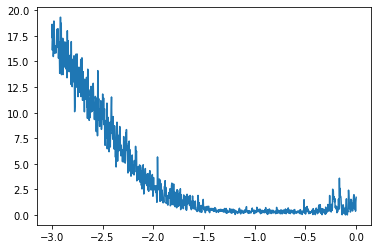

In [119]:
plt.plot(lri, lossi)

Can be seen that around exp(-1) is a good learning rate

### Splitting datasets into training set, dev/validation set, test set
If the dataset is not big, can use 80-10-10 ratio <br>
But if the dataset is large enough, e.g. 1.000.000, we can go to an extreme ratio of 98-1-1


In [121]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:

    #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [122]:
len(words)

32033

In [127]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [128]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [129]:
for p in parameters:
    p.requires_grad = True

In [169]:
lri = []
lossi = []
for i in range(10000):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
  #lr = lrs[i]
    lr = 0.005
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
#     stepi.append(i)
#     lossi.append(loss.log10().item())

In [170]:
print(loss.item())

2.260570526123047


### Evaluate on test dataset

In [171]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4144, grad_fn=<NllLossBackward0>)

## Scaling up the neural network architecture (Enlarge the number of neuron in the hidden layer)

In [173]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [172]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((3*2, 300), generator=g) # bump the neuron from 100 to 300
b1 = torch.randn(300, generator=g) 
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [174]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lri = []
lossi = []
stepi = []

In [207]:
for i in range(50000):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 300)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
  #lr = lrs[i]
    lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
#     stepi.append(i)
#     lossi.append(loss.log10().item())

In [208]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3319, grad_fn=<NllLossBackward0>)

In [209]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3288, grad_fn=<NllLossBackward0>)

Both error on training set and dev set are similar -> we are not overfitting <br>
But it is still considered high -> we are underfitting <br>
We suspect that there is a bottleneck on the character embedding. The 2d shape might not be able to represent the information of 27 features.<br><br>
So, we are going to increase the output size of the character embedding process.

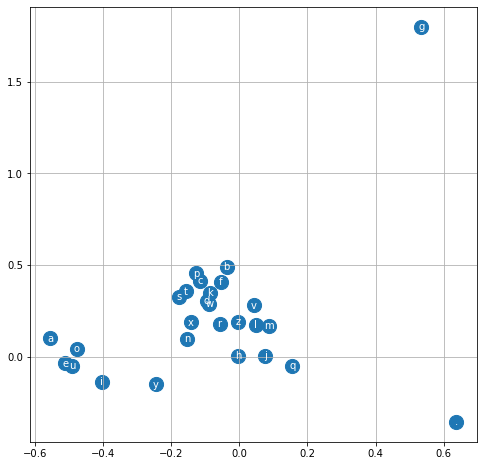

In [210]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Scaling up the neural network architecture (Pump up the number of output of the embedding process)

In [212]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [213]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # bump up the # embedding output to 10
W1 = torch.randn((3*10, 300), generator=g) # bump the neuron from 100 to 300
b1 = torch.randn(300, generator=g) 
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [214]:
lri = []
lossi = []
stepi = []

In [223]:
for i in range(50000):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 300)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
  #lr = lrs[i]
    lr = 0.01
    #lr = 0.1 if i < 10000 else 0.01 # an learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

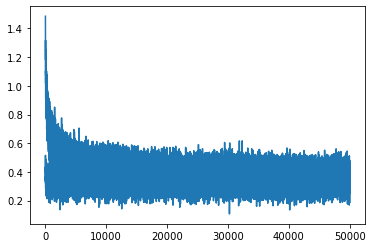

In [222]:
plt.plot(stepi, lossi)

In [224]:
emb = C[Xtr] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1548, grad_fn=<NllLossBackward0>)

In [225]:
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1934, grad_fn=<NllLossBackward0>)

The train error and dev error start to diverge, that means that now our neural network is big enough that it can start to overfit

In [232]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d) (1, 3, 10)
        #print(emb.view(1, -1).shape)
        h = torch.tanh(emb.view(1, 30) @ W1 + b1) # log of counts
        logits = h @ W2 + b2 # counts
        probs = F.softmax(logits, dim=1) # probability distribution 
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sampling from probability distribution
        context = context[1:] + [ix]  # crop and append to keep the length equals to block_size
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

eriagimyanniee.
mel.
ryla.
rethruthadraeg.
adee.
deelin.
shy.
jen.
edenslen.
naraelynn.
hopelin.
shubergihianest.
jairenleigh.
terianu.
zened.
ruyah.
faeley.
majahshayla.
hil.
calynn.
